Importing the Libraries

In [266]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk, warnings, string
warnings.filterwarnings('ignore')
from nltk.corpus import stopwords
from symspellpy import Verbosity, SymSpell
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import math
import xgboost as xgb
from sklearn import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Dense,GlobalMaxPooling1D,Embedding
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

An outlook on the Dataset

In [267]:
df = pd.read_csv('Reddit_Data.csv')
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [268]:
df.shape

(37249, 2)

In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB


In [270]:
df.describe()

,category
count,37249.000000
mean,0.202771
std,0.778515
min,-1.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [271]:
df.isnull().sum()

clean_comment    100
category           0
dtype: int64

In [272]:
df = df.dropna()
df.isnull().sum()

clean_comment    0
category         0
dtype: int64

In [273]:
df.shape

(37149, 2)

Removing Duplicates

In [274]:
df.loc[df.duplicated()]

,clean_comment,category
375,,0
392,,0
617,aurum mom,0
651,,0
1222,,0
...,...,...
36915,who won,0
37044,,0
37125,hari,0
37158,top kek,1


In [275]:
df=df.drop_duplicates()
df.loc[df.duplicated()]

,clean_comment,category


NLP

In [276]:
def text_preprocess(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return ' '.join([word for word in nopunc.split()])

In [277]:
df.clean_comment = df.clean_comment.apply(text_preprocess)
df.head()

,clean_comment,category
0,family mormon have never tried explain them th...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [278]:
stemmer = SnowballStemmer('english')

def stem_words(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

In [279]:
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

In [280]:
symspell = SymSpell()

def spelling_correction(text):
    correct_spellings = []
    for token in text.split():
        x = symspell.lookup(token,Verbosity.CLOSEST,max_edit_distance=2,include_unknown=True)[0].__str__()
        y = x.split(',')[0]
        correct_spellings.append(y)
    return ' '.join(correct_spellings)

In [281]:
#df.clean_comment = df.clean_comment.apply(stem_words)
#df.clean_comment = df.clean_comment.apply(lemmatize_words)
#df.clean_comment = df.clean_comment.apply(spelling_correction)
#df.head()

In [282]:
df.loc[df.clean_comment.str.isspace()]

,clean_comment,category


Exploratory Data Analysis (EDA)

In [283]:
df.category = df.category.replace([-1.0,0.0,1.0],['Negative','Neutral','Positive'])
df.head()

,clean_comment,category
0,family mormon have never tried explain them th...,Positive
1,buddhism has very much lot compatible with chr...,Positive
2,seriously don say thing first all they won get...,Negative
3,what you have learned yours and only yours wha...,Neutral
4,for your own benefit you may want read living ...,Positive


<AxesSubplot: xlabel='category', ylabel='count'>

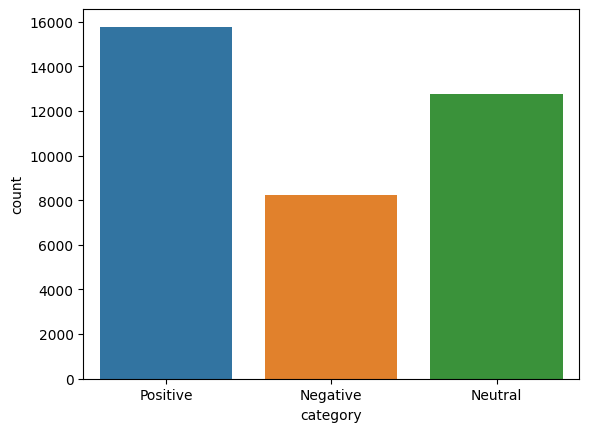

In [284]:
sns.countplot(x='category', data = df)

In [285]:
positive_comments = ' '.join(list(df[df.category == 'Positive']['clean_comment']))
negative_comments = ' '.join(list(df[df.category == 'Negative']['clean_comment']))
neutral_comments = ' '.join(list(df[df.category == 'Neutral']['clean_comment']))

In [286]:
def create_word_cloud(data):
    data_wc = WordCloud(width=600,height=512).generate(data)
    plt.figure(figsize=(13,9))
    plt.imshow(data_wc)
    plt.show()

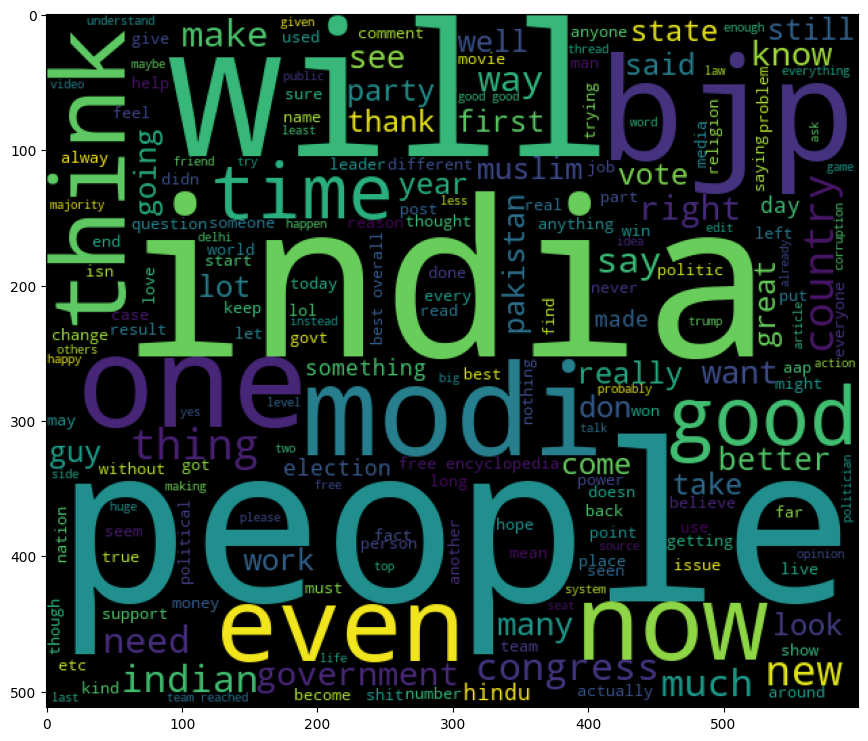

In [287]:
create_word_cloud(positive_comments)

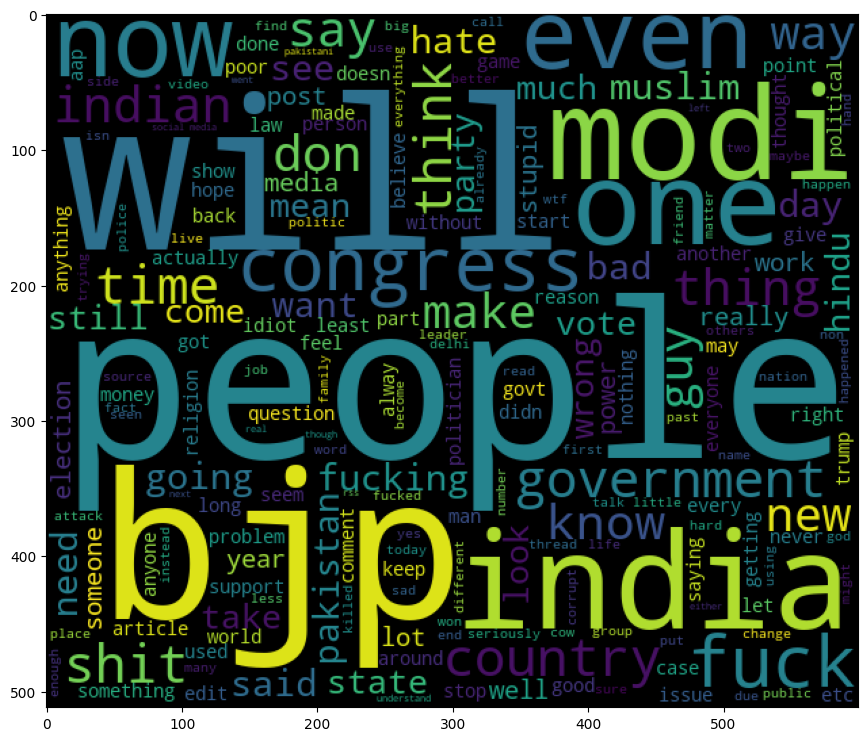

In [288]:
create_word_cloud(negative_comments)

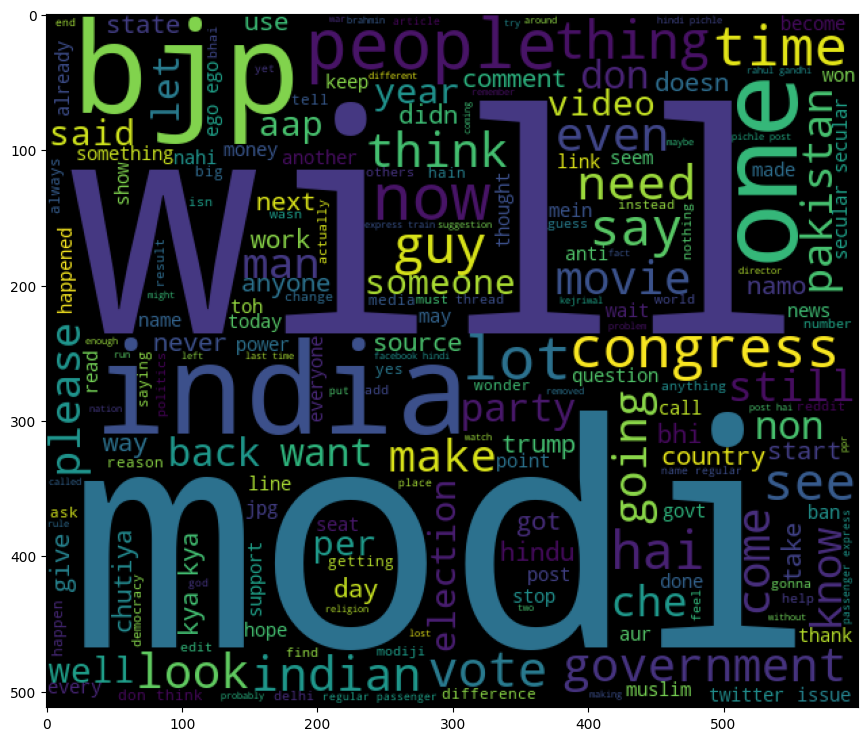

In [289]:
create_word_cloud(neutral_comments)

Defining X and y

In [290]:
X = df['clean_comment']
y = df['category']

In [291]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
y

array([2, 2, 0, ..., 1, 2, 1])

TRAIN TEST SPLIT

In [292]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=1)
print("X_train Shape : ",X_train.shape)
print("y_train Shape : ",y_train.shape)
print("X_test Shape : ",X_test.shape)
print("y_test Shape : ",y_test.shape)

X_train Shape :  (25759,)
y_train Shape :  (25759,)
X_test Shape :  (11040,)
y_test Shape :  (11040,)


Text Vectorization

In [293]:
tfidf = TfidfVectorizer()
X_train_vect = tfidf.fit_transform(X_train)
X_test_vect = tfidf.transform(X_test)

In [294]:
#tfidf.vocabulary_

In [295]:
len(tfidf.vocabulary_)

44105

XGBoost

In [296]:
modelxg = xgb.XGBClassifier()
modelxg.fit(X_train_vect, y_train)
yhat = modelxg.predict(X_test_vect)
print(confusion_matrix(y_test,yhat))
print(classification_report(y_test,yhat))
accuracyscores = accuracy_score(y_test,yhat)

[[1563  378  496]
 [  18 3704  103]
 [ 225  558 3995]]
              precision    recall  f1-score   support

           0       0.87      0.64      0.74      2437
           1       0.80      0.97      0.88      3825
           2       0.87      0.84      0.85      4778

    accuracy                           0.84     11040
   macro avg       0.84      0.82      0.82     11040
weighted avg       0.84      0.84      0.83     11040



SEQUENCING TEXTS TO FEED INTO CNN

In [297]:
max_words=10000
tokenizer=Tokenizer(max_words)
tokenizer.fit_on_texts(X_train)
sequence_train=tokenizer.texts_to_sequences(X_train)
sequence_test=tokenizer.texts_to_sequences(X_test)

In [298]:
word2vec=tokenizer.word_index
V=len(word2vec)
V

45280

In [299]:
data_train=pad_sequences(sequence_train)
data_train.shape

(25759, 1205)

In [300]:
T=data_train.shape[1]
data_test=pad_sequences(sequence_test,maxlen=T)
data_test.shape

(11040, 1205)

DEFINING CNN

In [301]:
D=20
i=Input((T,))
x=Embedding(V+1,D)(i)
x=Conv1D(32,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(64,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(128,3,activation='relu')(x)
x=GlobalMaxPooling1D()(x)
x=Dense(5,activation='softmax')(x)
modelcnn=Model(i,x)
modelcnn.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 1205)]            0         
                                                                 
 embedding_12 (Embedding)    (None, 1205, 20)          905620    
                                                                 
 conv1d_30 (Conv1D)          (None, 1203, 32)          1952      
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 401, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_31 (Conv1D)          (None, 399, 64)           6208      
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 133, 64)          0         
 g1D)                                                     

In [302]:
modelcnn.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
cnn_senti=modelcnn.fit(data_train,y_train,validation_data=(data_test,y_test),epochs=3,batch_size=25)

Epoch 1/3
1031/1031 [==============================] - 41s 39ms/step - loss: 0.6154 - accuracy: 0.7465 - val_loss: 0.3795 - val_accuracy: 0.8715
Epoch 2/3
1031/1031 [==============================] - 40s 39ms/step - loss: 0.2487 - accuracy: 0.9195 - val_loss: 0.2339 - val_accuracy: 0.9270
Epoch 3/3
1031/1031 [==============================] - 40s 39ms/step - loss: 0.1341 - accuracy: 0.9604 - val_loss: 0.2475 - val_accuracy: 0.9269


In [303]:
yhatcnn=modelcnn.predict(data_test)
yhatcnn

345/345 [==============================] - 3s 10ms/step


array([[1.4070672e-03, 9.9522889e-01, 3.3573105e-03, 2.8308821e-06,
        3.9521356e-06],
       [5.2734021e-02, 4.9124457e-02, 8.9814144e-01, 1.7812290e-21,
        2.8502736e-22],
       [1.0373528e-06, 2.1180662e-05, 9.9997771e-01, 1.3748973e-15,
        2.1641891e-15],
       ...,
       [1.4995127e-03, 9.9352258e-01, 4.9731089e-03, 2.0593056e-06,
        2.8831444e-06],
       [5.1309058e-04, 7.8037335e-04, 9.9870646e-01, 1.0938627e-18,
        1.0951689e-19],
       [2.8232282e-03, 9.9278599e-01, 4.3857838e-03, 2.1085073e-06,
        2.8310308e-06]], dtype=float32)

In [304]:
yhatcnn=np.argmax(yhatcnn,axis=1)
yhatcnn

array([1, 2, 2, ..., 1, 2, 1], dtype=int64)

Text(50.722222222222214, 0.5, 'predicted')

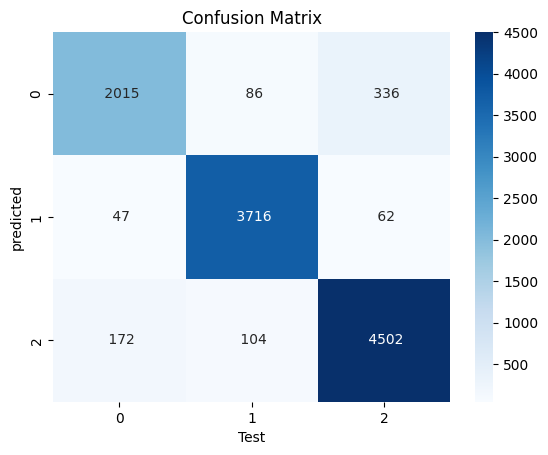

In [305]:
cm=confusion_matrix(y_test,yhatcnn)
ax=sns.heatmap(cm,annot=True,cmap='Blues',fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Test')
ax.set_ylabel('predicted')

In [306]:
print(classification_report(y_test,yhatcnn))

              precision    recall  f1-score   support

           0       0.90      0.83      0.86      2437
           1       0.95      0.97      0.96      3825
           2       0.92      0.94      0.93      4778

    accuracy                           0.93     11040
   macro avg       0.92      0.91      0.92     11040
weighted avg       0.93      0.93      0.93     11040

